# Torch Distributions

---

Following the design of [Tensorflow Distributions](https://arxiv.org/abs/1711.10604), good folks at PyTorch also created [Torch Distributions](https://pytorch.org/docs/stable/distributions.html) package of their own to have some simple parameterizable standard probability distributions. Since I work mostly with PyTorch at the moment, I decide to write some simple examples and scenarios where this package can reduce the amount of code I need to write.

## Why do I even need this?

## Show me the code

### A VAE (Variational Autoencoders) Example

Let's start with the official VAE example provided by the pytorch team [here](https://github.com/pytorch/examples/tree/master/vae).

#### Boilerplate imports and paths

We basically need some tools to

In [11]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.distributions as td
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

BATCH_SIZE = 128
EPOCHS = 10
LOG_INTERVAL = 50
SEED = 42
DATA_DIR = '/vulcan/scratch/kampta/data/mnist'

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    

#### Dataloaders

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


#### VAE

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#### Training a VAE

# Parameters: 652824
Train Epoch: 1 [0/60000 (0%)]	Loss: 548.016907
Train Epoch: 1 [6400/60000 (11%)]	Loss: 211.933273
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.600006
Train Epoch: 1 [19200/60000 (32%)]	Loss: 159.581924
Train Epoch: 1 [25600/60000 (43%)]	Loss: 151.227249
Train Epoch: 1 [32000/60000 (53%)]	Loss: 141.585632
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.612015
Train Epoch: 1 [44800/60000 (75%)]	Loss: 130.421722
Train Epoch: 1 [51200/60000 (85%)]	Loss: 134.600586
Train Epoch: 1 [57600/60000 (96%)]	Loss: 128.973724
====> Epoch: 1 Average loss: 163.9474
====> Test set loss: 128.0825


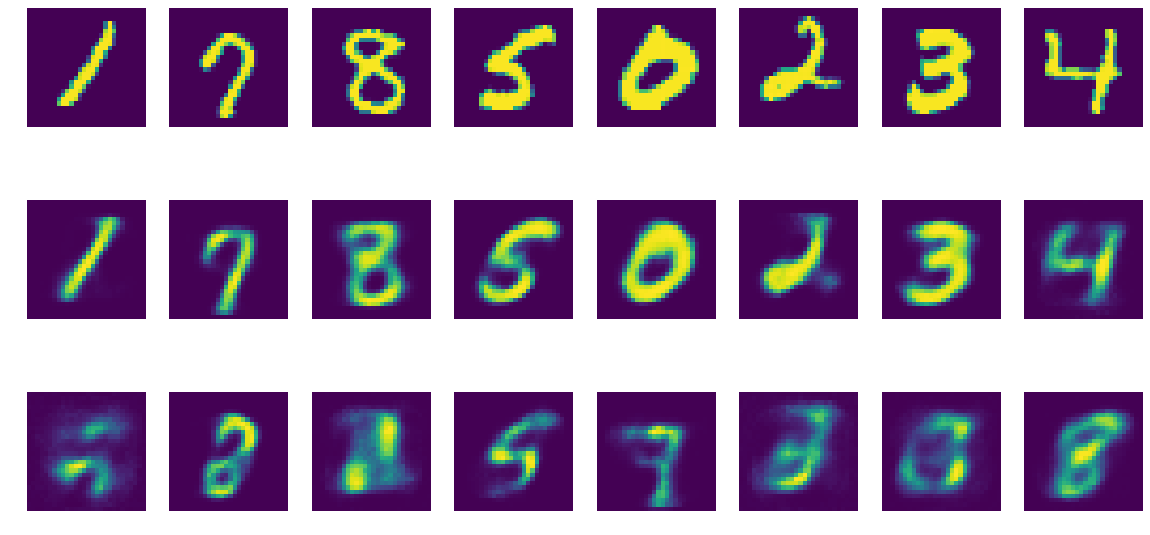

Train Epoch: 2 [0/60000 (0%)]	Loss: 132.774368
Train Epoch: 2 [6400/60000 (11%)]	Loss: 121.831337
Train Epoch: 2 [12800/60000 (21%)]	Loss: 128.155411
Train Epoch: 2 [19200/60000 (32%)]	Loss: 122.831207
Train Epoch: 2 [25600/60000 (43%)]	Loss: 122.669182
Train Epoch: 2 [32000/60000 (53%)]	Loss: 124.256889
Train Epoch: 2 [38400/60000 (64%)]	Loss: 123.530724
Train Epoch: 2 [44800/60000 (75%)]	Loss: 116.377815
Train Epoch: 2 [51200/60000 (85%)]	Loss: 119.159416
Train Epoch: 2 [57600/60000 (96%)]	Loss: 116.239319
====> Epoch: 2 Average loss: 121.4778
====> Test set loss: 115.7492


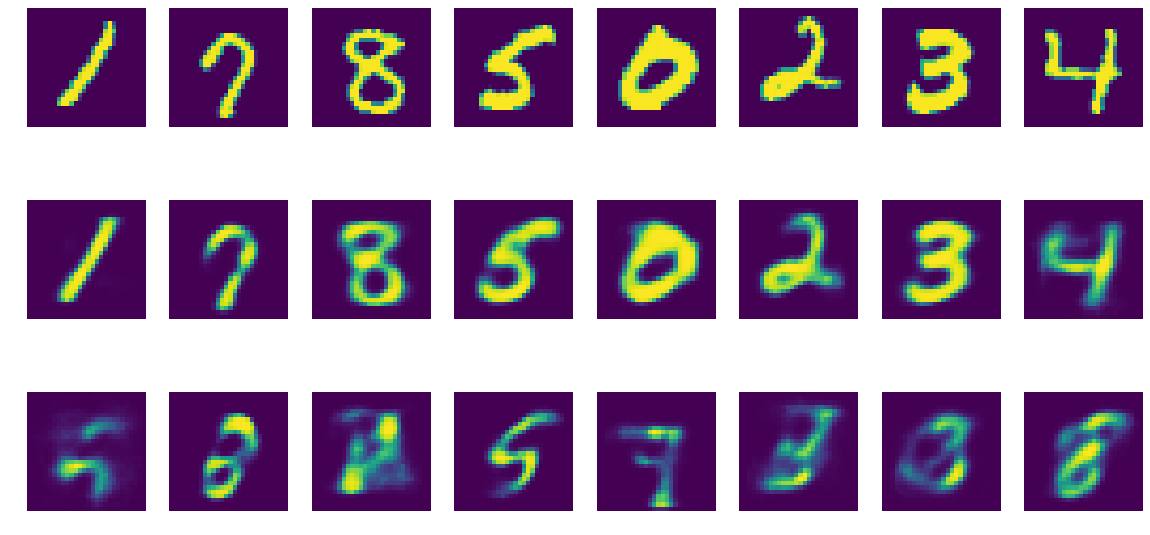

Train Epoch: 3 [0/60000 (0%)]	Loss: 117.758247
Train Epoch: 3 [6400/60000 (11%)]	Loss: 115.868301
Train Epoch: 3 [12800/60000 (21%)]	Loss: 119.501801
Train Epoch: 3 [19200/60000 (32%)]	Loss: 115.433716
Train Epoch: 3 [25600/60000 (43%)]	Loss: 114.656754
Train Epoch: 3 [32000/60000 (53%)]	Loss: 112.271225
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.532730
Train Epoch: 3 [44800/60000 (75%)]	Loss: 112.604782
Train Epoch: 3 [51200/60000 (85%)]	Loss: 114.017342
Train Epoch: 3 [57600/60000 (96%)]	Loss: 109.398499
====> Epoch: 3 Average loss: 114.4740
====> Test set loss: 112.1665


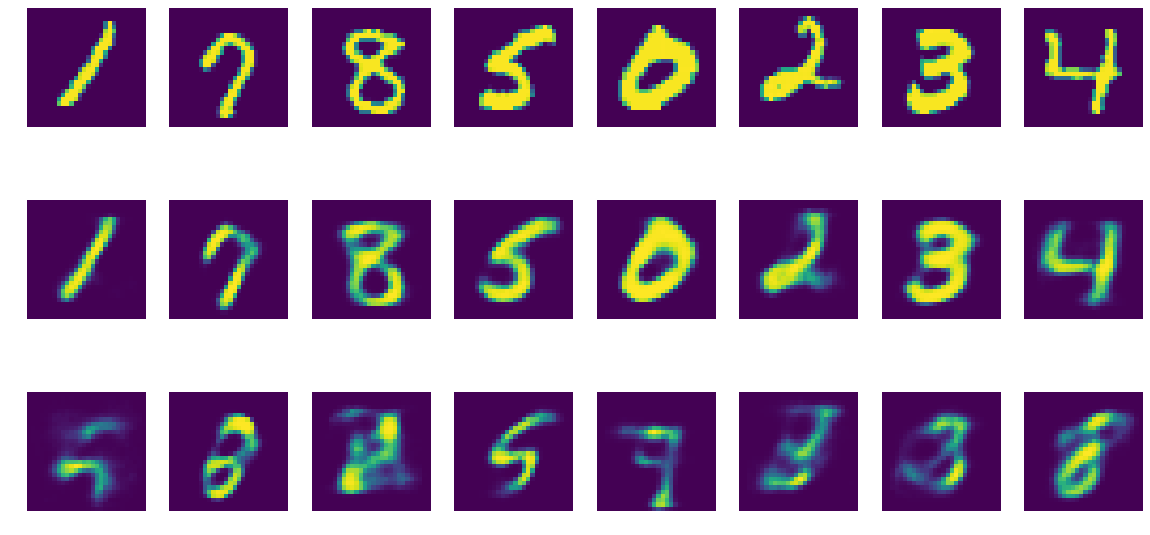

Train Epoch: 4 [0/60000 (0%)]	Loss: 109.866493
Train Epoch: 4 [6400/60000 (11%)]	Loss: 111.462540
Train Epoch: 4 [12800/60000 (21%)]	Loss: 107.884232
Train Epoch: 4 [19200/60000 (32%)]	Loss: 113.712166
Train Epoch: 4 [25600/60000 (43%)]	Loss: 109.649185
Train Epoch: 4 [32000/60000 (53%)]	Loss: 108.801208
Train Epoch: 4 [38400/60000 (64%)]	Loss: 110.537613
Train Epoch: 4 [44800/60000 (75%)]	Loss: 111.857330
Train Epoch: 4 [51200/60000 (85%)]	Loss: 110.636650
Train Epoch: 4 [57600/60000 (96%)]	Loss: 111.202812
====> Epoch: 4 Average loss: 111.5007
====> Test set loss: 109.6654


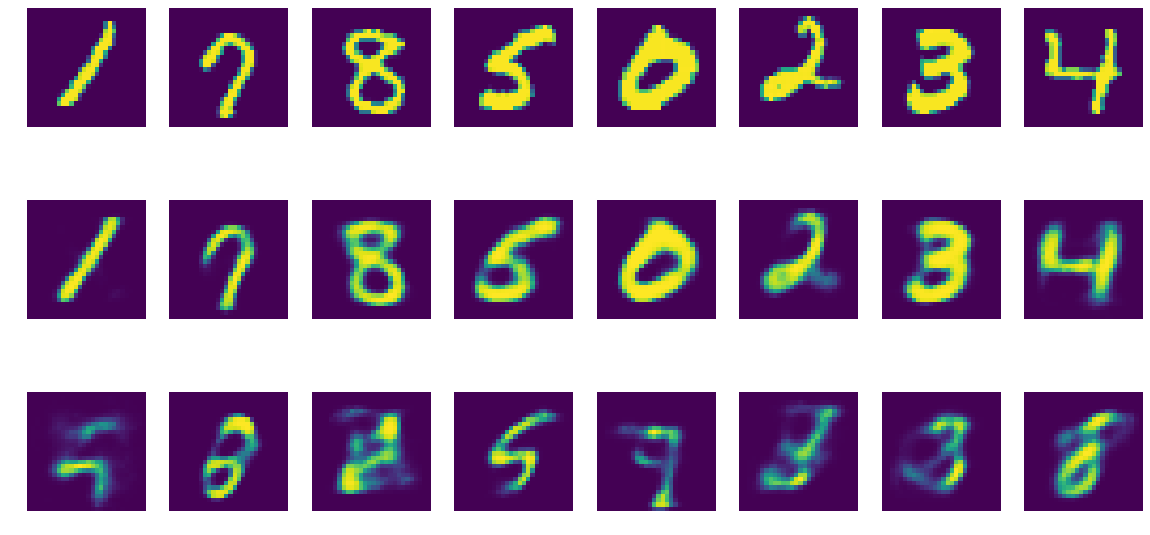

Train Epoch: 5 [0/60000 (0%)]	Loss: 105.494843
Train Epoch: 5 [6400/60000 (11%)]	Loss: 114.785316
Train Epoch: 5 [12800/60000 (21%)]	Loss: 104.806427
Train Epoch: 5 [19200/60000 (32%)]	Loss: 106.974426
Train Epoch: 5 [25600/60000 (43%)]	Loss: 116.579620
Train Epoch: 5 [32000/60000 (53%)]	Loss: 109.975815
Train Epoch: 5 [38400/60000 (64%)]	Loss: 112.494156
Train Epoch: 5 [44800/60000 (75%)]	Loss: 112.834885
Train Epoch: 5 [51200/60000 (85%)]	Loss: 111.491074
Train Epoch: 5 [57600/60000 (96%)]	Loss: 107.868027
====> Epoch: 5 Average loss: 109.7821
====> Test set loss: 108.2262


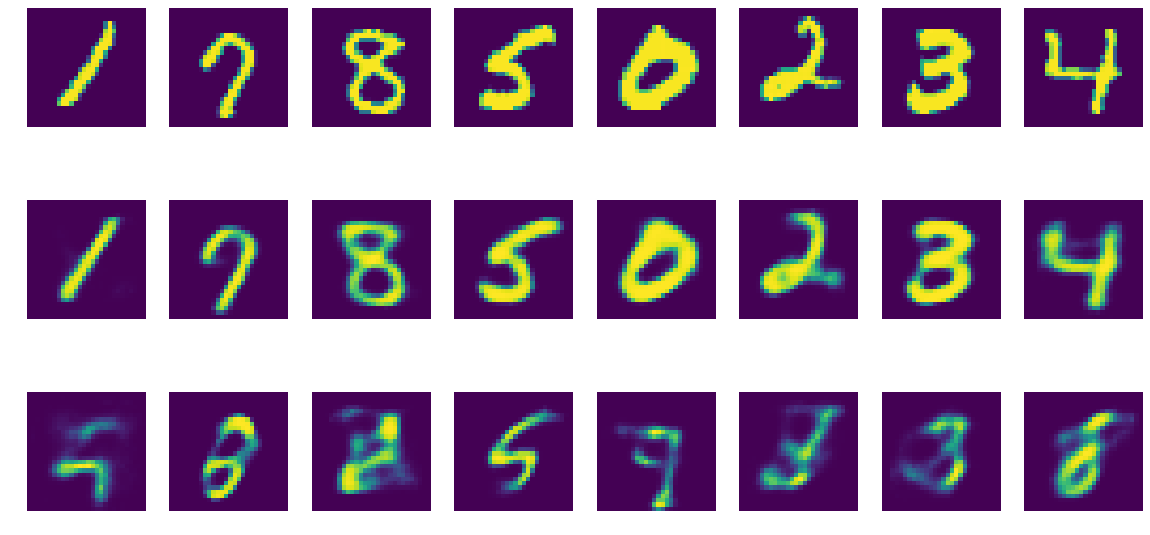

Train Epoch: 6 [0/60000 (0%)]	Loss: 111.274048
Train Epoch: 6 [6400/60000 (11%)]	Loss: 109.544754
Train Epoch: 6 [12800/60000 (21%)]	Loss: 107.790192
Train Epoch: 6 [19200/60000 (32%)]	Loss: 110.732101
Train Epoch: 6 [25600/60000 (43%)]	Loss: 109.053360
Train Epoch: 6 [32000/60000 (53%)]	Loss: 105.999092
Train Epoch: 6 [38400/60000 (64%)]	Loss: 109.042534
Train Epoch: 6 [44800/60000 (75%)]	Loss: 108.868774
Train Epoch: 6 [51200/60000 (85%)]	Loss: 108.712646
Train Epoch: 6 [57600/60000 (96%)]	Loss: 110.005440
====> Epoch: 6 Average loss: 108.5859
====> Test set loss: 107.4110


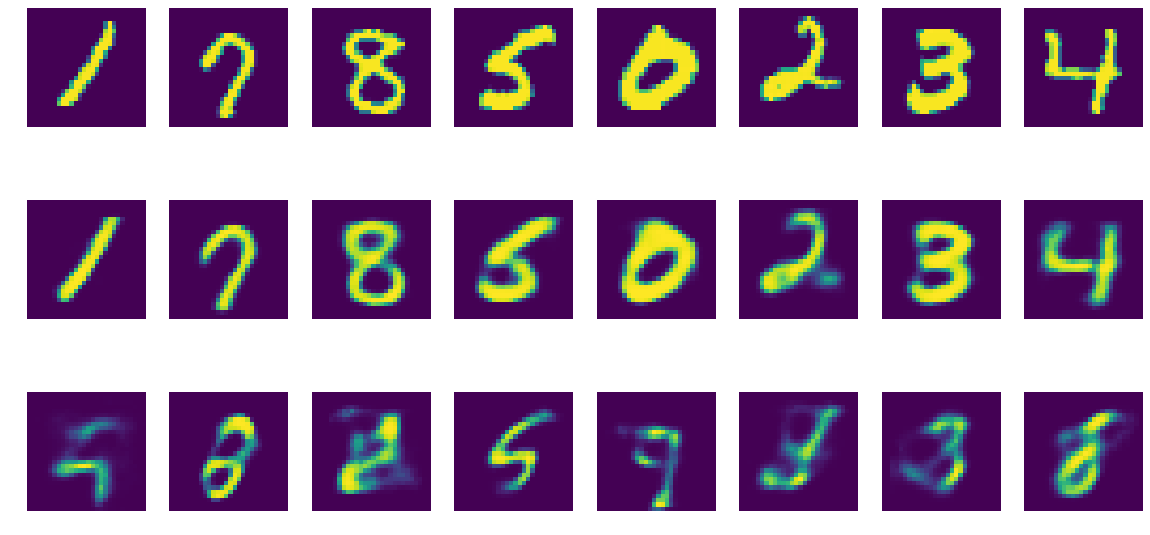

Train Epoch: 7 [0/60000 (0%)]	Loss: 107.185127
Train Epoch: 7 [6400/60000 (11%)]	Loss: 109.319519
Train Epoch: 7 [12800/60000 (21%)]	Loss: 108.759293
Train Epoch: 7 [19200/60000 (32%)]	Loss: 103.861008
Train Epoch: 7 [25600/60000 (43%)]	Loss: 109.760406
Train Epoch: 7 [32000/60000 (53%)]	Loss: 106.871147
Train Epoch: 7 [38400/60000 (64%)]	Loss: 104.355782
Train Epoch: 7 [44800/60000 (75%)]	Loss: 108.230682
Train Epoch: 7 [51200/60000 (85%)]	Loss: 109.612541
Train Epoch: 7 [57600/60000 (96%)]	Loss: 105.879593
====> Epoch: 7 Average loss: 107.6869
====> Test set loss: 106.9593


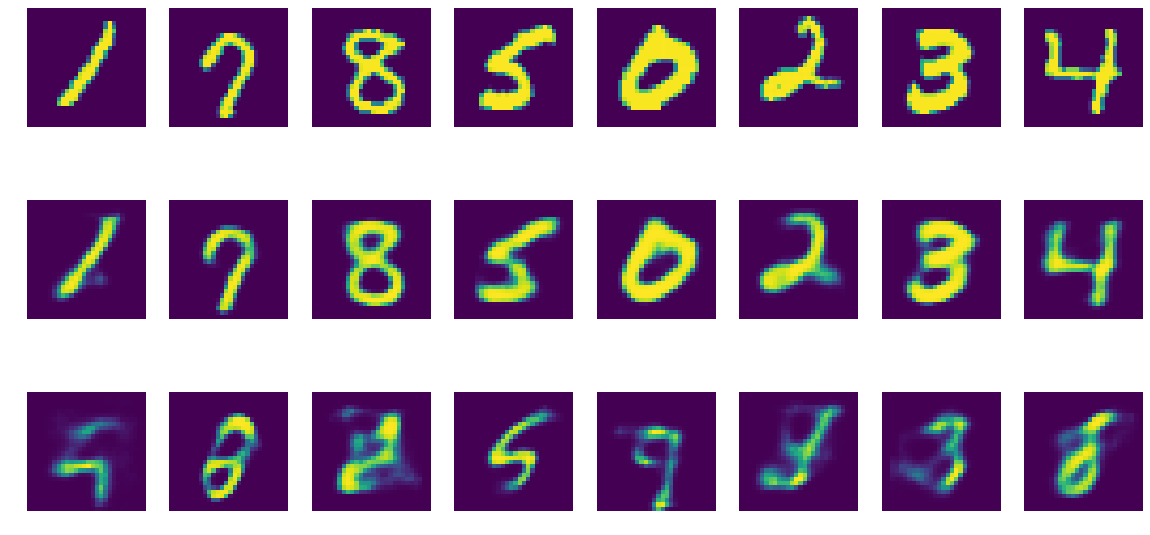

Train Epoch: 8 [0/60000 (0%)]	Loss: 109.748581
Train Epoch: 8 [6400/60000 (11%)]	Loss: 105.452736
Train Epoch: 8 [12800/60000 (21%)]	Loss: 108.426064
Train Epoch: 8 [19200/60000 (32%)]	Loss: 105.039703
Train Epoch: 8 [25600/60000 (43%)]	Loss: 110.166100
Train Epoch: 8 [32000/60000 (53%)]	Loss: 102.453079
Train Epoch: 8 [38400/60000 (64%)]	Loss: 108.498245
Train Epoch: 8 [44800/60000 (75%)]	Loss: 107.011147
Train Epoch: 8 [51200/60000 (85%)]	Loss: 107.766998
Train Epoch: 8 [57600/60000 (96%)]	Loss: 106.658859
====> Epoch: 8 Average loss: 107.0981
====> Test set loss: 106.1444


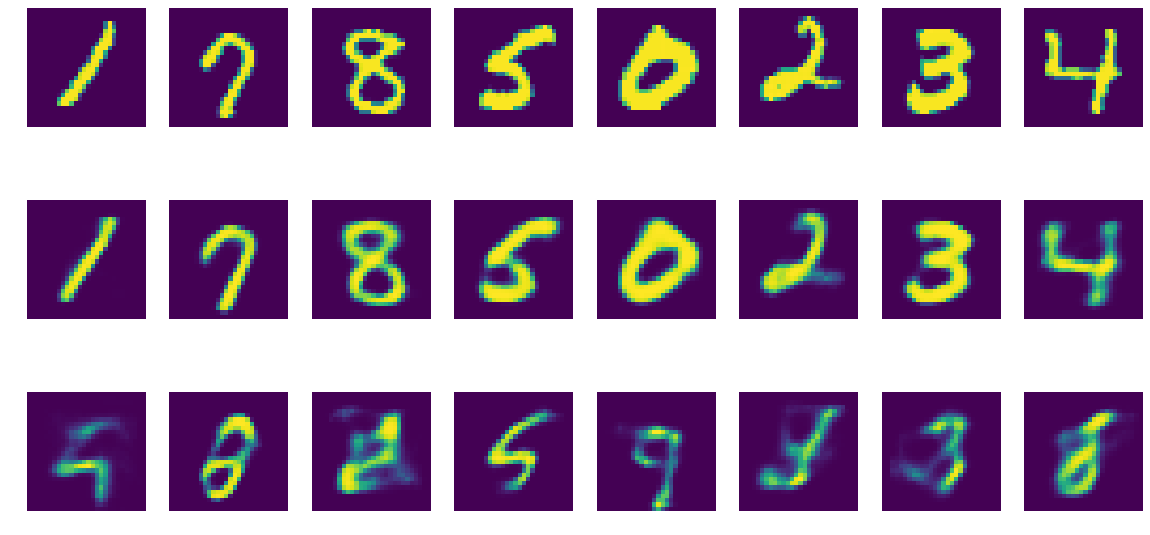

Train Epoch: 9 [0/60000 (0%)]	Loss: 103.903748
Train Epoch: 9 [6400/60000 (11%)]	Loss: 107.988922
Train Epoch: 9 [12800/60000 (21%)]	Loss: 105.608124
Train Epoch: 9 [19200/60000 (32%)]	Loss: 108.027405
Train Epoch: 9 [25600/60000 (43%)]	Loss: 105.213722
Train Epoch: 9 [32000/60000 (53%)]	Loss: 102.362183
Train Epoch: 9 [38400/60000 (64%)]	Loss: 109.031479
Train Epoch: 9 [44800/60000 (75%)]	Loss: 108.366745
Train Epoch: 9 [51200/60000 (85%)]	Loss: 111.629997
Train Epoch: 9 [57600/60000 (96%)]	Loss: 108.692703
====> Epoch: 9 Average loss: 106.5592
====> Test set loss: 106.1157


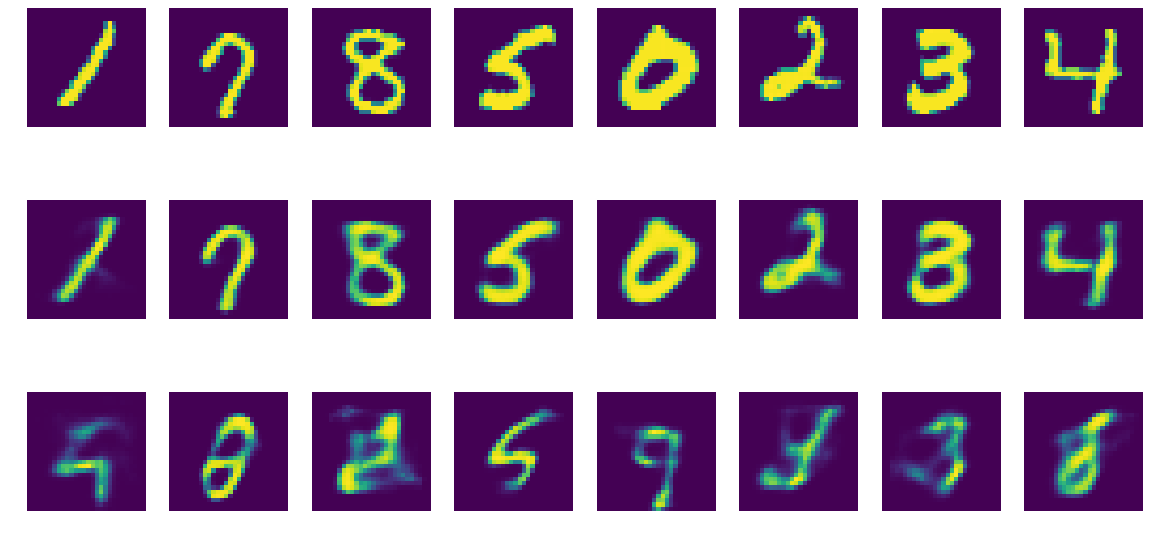

Train Epoch: 10 [0/60000 (0%)]	Loss: 106.893112
Train Epoch: 10 [6400/60000 (11%)]	Loss: 105.822052
Train Epoch: 10 [12800/60000 (21%)]	Loss: 103.866310
Train Epoch: 10 [19200/60000 (32%)]	Loss: 108.093658
Train Epoch: 10 [25600/60000 (43%)]	Loss: 105.928749
Train Epoch: 10 [32000/60000 (53%)]	Loss: 102.009857
Train Epoch: 10 [38400/60000 (64%)]	Loss: 105.576622
Train Epoch: 10 [44800/60000 (75%)]	Loss: 102.930862
Train Epoch: 10 [51200/60000 (85%)]	Loss: 107.445892
Train Epoch: 10 [57600/60000 (96%)]	Loss: 109.275642
====> Epoch: 10 Average loss: 106.1588
====> Test set loss: 105.5404


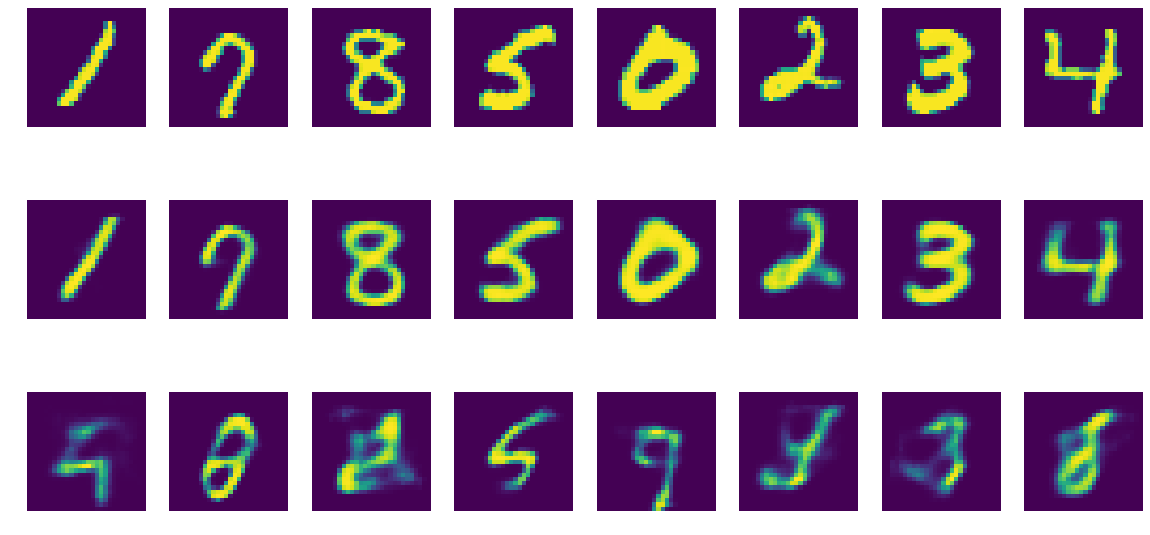

In [10]:
model = VAE().to(device)
print(f"# Parameters: {count_parameters(model)}")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

fixed_z = torch.randn(8, 20).to(device)
fixed_x, _ = next(iter(test_loader))
fixed_x = fixed_x[:8].to(device)

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
    
    fig, axs = plt.subplots(3, 8, figsize=(20, 10))
    with torch.no_grad():
        # Reconstruction
        recon_x, *_ = model(fixed_x)
        for h in range(8):
            axs[0][h].imshow(fixed_x.cpu().numpy()[h].reshape(28, 28))
            axs[0][h].set_axis_off()

        for h in range(8):
            axs[1][h].imshow(recon_x.cpu().numpy()[h].reshape(28, 28))
            axs[1][h].set_axis_off()

        # Generated samples
        fixed_z_gen = model.decode(fixed_z).cpu().numpy()
        
        for h in range(8):
            axs[2][h].imshow(fixed_z_gen[h].reshape(28, 28))
            axs[2][h].set_axis_off()
        plt.show()


### What does this have to do with Torch Distributions?

In [25]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        std = torch.exp(0.5*logvar)
        z = td.normal.Normal(mu, std)
        z_hat = z.rsample()
        return self.decode(z_hat), z


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, z):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    standard_normal = td.normal.Normal(torch.zeros_like(z.loc), torch.ones_like(z.scale))
    KLD = torch.sum(td.kl.kl_divergence(z, standard_normal))

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, z = model(data)
        loss = loss_function(recon_batch, data, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, z = model(data)
            test_loss += loss_function(recon_batch, data, z).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Parameters: 652824
Train Epoch: 1 [0/60000 (0%)]	Loss: 549.136902
Train Epoch: 1 [6400/60000 (11%)]	Loss: 215.732330
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.169800
Train Epoch: 1 [19200/60000 (32%)]	Loss: 161.118454
Train Epoch: 1 [25600/60000 (43%)]	Loss: 154.094055
Train Epoch: 1 [32000/60000 (53%)]	Loss: 146.831131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 140.471451
Train Epoch: 1 [44800/60000 (75%)]	Loss: 135.741455
Train Epoch: 1 [51200/60000 (85%)]	Loss: 133.110733
Train Epoch: 1 [57600/60000 (96%)]	Loss: 129.536011
====> Epoch: 1 Average loss: 164.5639
====> Test set loss: 127.1306


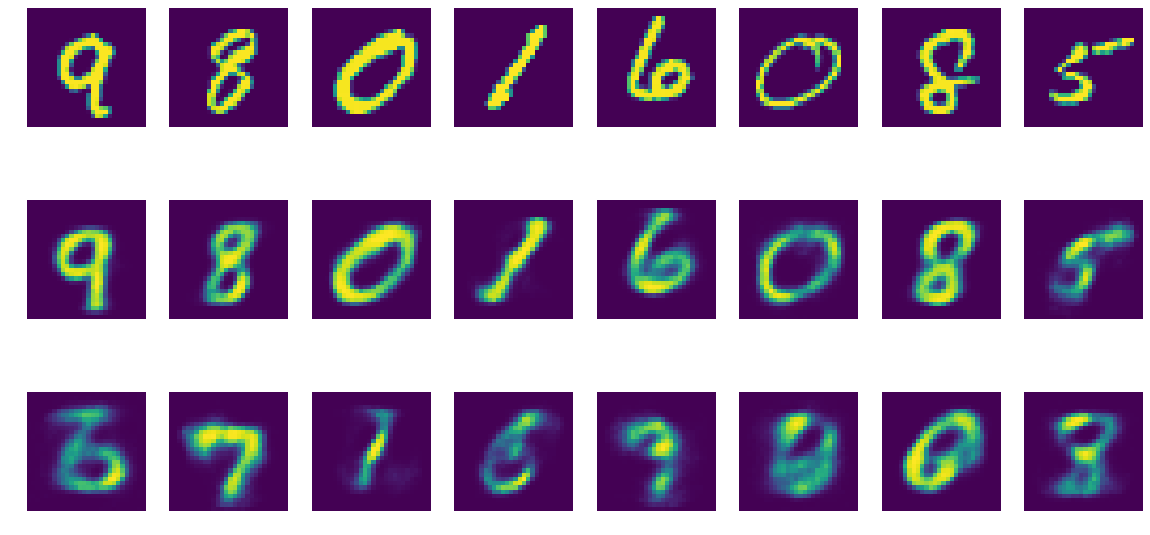

Train Epoch: 2 [0/60000 (0%)]	Loss: 131.367416
Train Epoch: 2 [6400/60000 (11%)]	Loss: 127.908218
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.452881
Train Epoch: 2 [19200/60000 (32%)]	Loss: 121.434387
Train Epoch: 2 [25600/60000 (43%)]	Loss: 119.028091
Train Epoch: 2 [32000/60000 (53%)]	Loss: 119.082512
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.116539
Train Epoch: 2 [44800/60000 (75%)]	Loss: 117.671204
Train Epoch: 2 [51200/60000 (85%)]	Loss: 113.540688
Train Epoch: 2 [57600/60000 (96%)]	Loss: 113.879295
====> Epoch: 2 Average loss: 121.2717
====> Test set loss: 115.7727


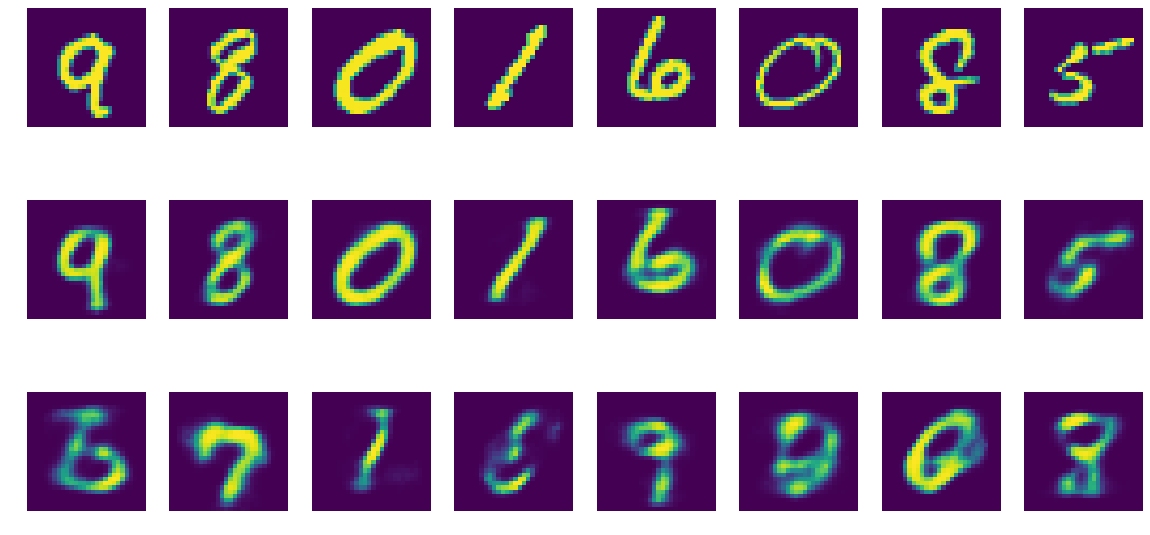

Train Epoch: 3 [0/60000 (0%)]	Loss: 114.847939
Train Epoch: 3 [6400/60000 (11%)]	Loss: 116.806656
Train Epoch: 3 [12800/60000 (21%)]	Loss: 112.952164
Train Epoch: 3 [19200/60000 (32%)]	Loss: 112.632492
Train Epoch: 3 [25600/60000 (43%)]	Loss: 114.475365
Train Epoch: 3 [32000/60000 (53%)]	Loss: 115.070114
Train Epoch: 3 [38400/60000 (64%)]	Loss: 112.305252
Train Epoch: 3 [44800/60000 (75%)]	Loss: 114.832230
Train Epoch: 3 [51200/60000 (85%)]	Loss: 118.164764
Train Epoch: 3 [57600/60000 (96%)]	Loss: 115.491371
====> Epoch: 3 Average loss: 114.2858
====> Test set loss: 111.5115


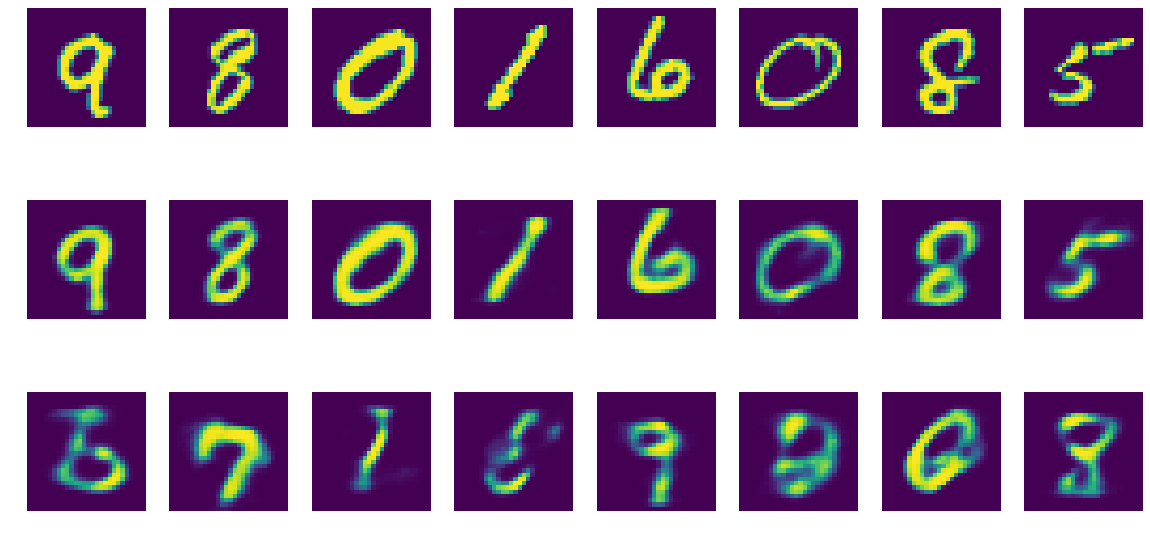

Train Epoch: 4 [0/60000 (0%)]	Loss: 113.388168
Train Epoch: 4 [6400/60000 (11%)]	Loss: 113.945206
Train Epoch: 4 [12800/60000 (21%)]	Loss: 113.285950
Train Epoch: 4 [19200/60000 (32%)]	Loss: 111.085434
Train Epoch: 4 [25600/60000 (43%)]	Loss: 114.077309
Train Epoch: 4 [32000/60000 (53%)]	Loss: 114.421631
Train Epoch: 4 [38400/60000 (64%)]	Loss: 111.601151
Train Epoch: 4 [44800/60000 (75%)]	Loss: 108.206398
Train Epoch: 4 [51200/60000 (85%)]	Loss: 109.608192
Train Epoch: 4 [57600/60000 (96%)]	Loss: 113.328995
====> Epoch: 4 Average loss: 111.3444
====> Test set loss: 109.3997


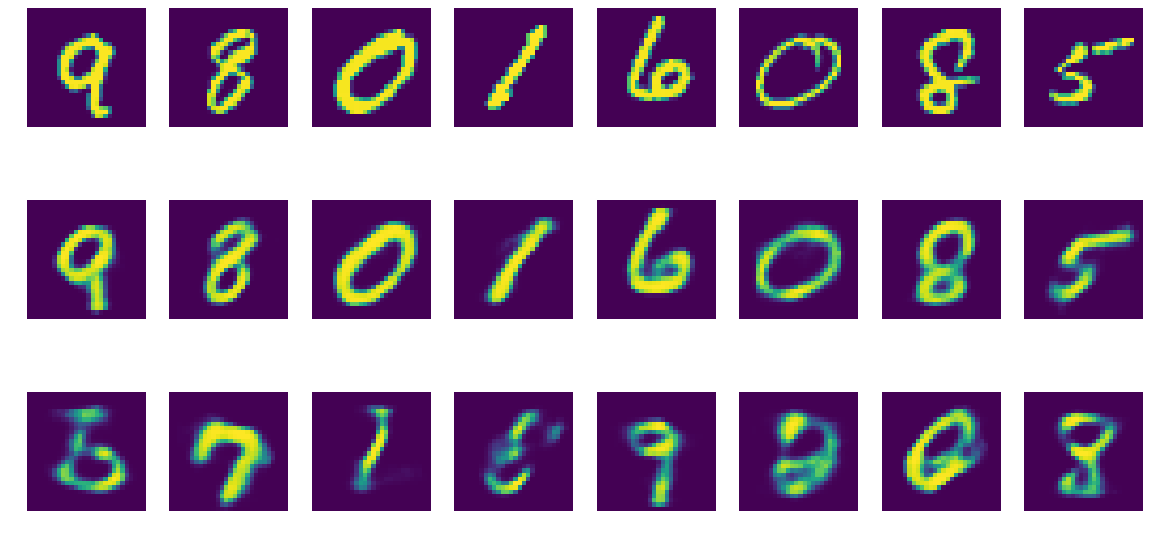

Train Epoch: 5 [0/60000 (0%)]	Loss: 111.804047
Train Epoch: 5 [6400/60000 (11%)]	Loss: 108.120224
Train Epoch: 5 [12800/60000 (21%)]	Loss: 112.718216
Train Epoch: 5 [19200/60000 (32%)]	Loss: 110.080513
Train Epoch: 5 [25600/60000 (43%)]	Loss: 110.439850
Train Epoch: 5 [32000/60000 (53%)]	Loss: 105.522179
Train Epoch: 5 [38400/60000 (64%)]	Loss: 107.330772
Train Epoch: 5 [44800/60000 (75%)]	Loss: 106.629929
Train Epoch: 5 [51200/60000 (85%)]	Loss: 113.857910
Train Epoch: 5 [57600/60000 (96%)]	Loss: 106.871964
====> Epoch: 5 Average loss: 109.6745
====> Test set loss: 108.4368


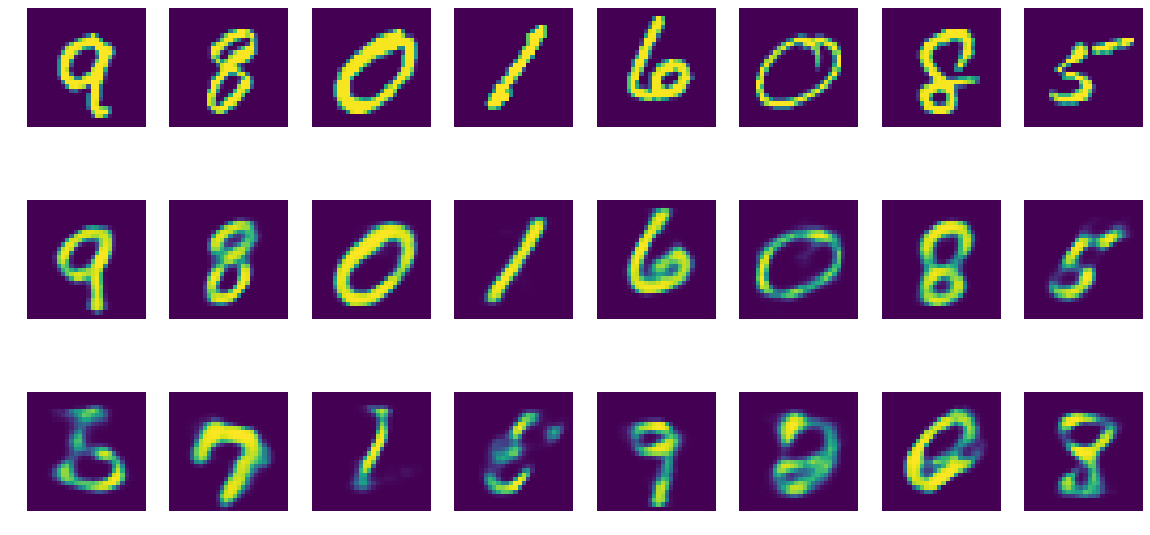

Train Epoch: 6 [0/60000 (0%)]	Loss: 108.622910
Train Epoch: 6 [6400/60000 (11%)]	Loss: 109.391510
Train Epoch: 6 [12800/60000 (21%)]	Loss: 106.003616
Train Epoch: 6 [19200/60000 (32%)]	Loss: 109.799591
Train Epoch: 6 [25600/60000 (43%)]	Loss: 108.032928
Train Epoch: 6 [32000/60000 (53%)]	Loss: 112.572372
Train Epoch: 6 [38400/60000 (64%)]	Loss: 107.681404
Train Epoch: 6 [44800/60000 (75%)]	Loss: 109.508041
Train Epoch: 6 [51200/60000 (85%)]	Loss: 109.397034
Train Epoch: 6 [57600/60000 (96%)]	Loss: 109.796364
====> Epoch: 6 Average loss: 108.5418
====> Test set loss: 107.2543


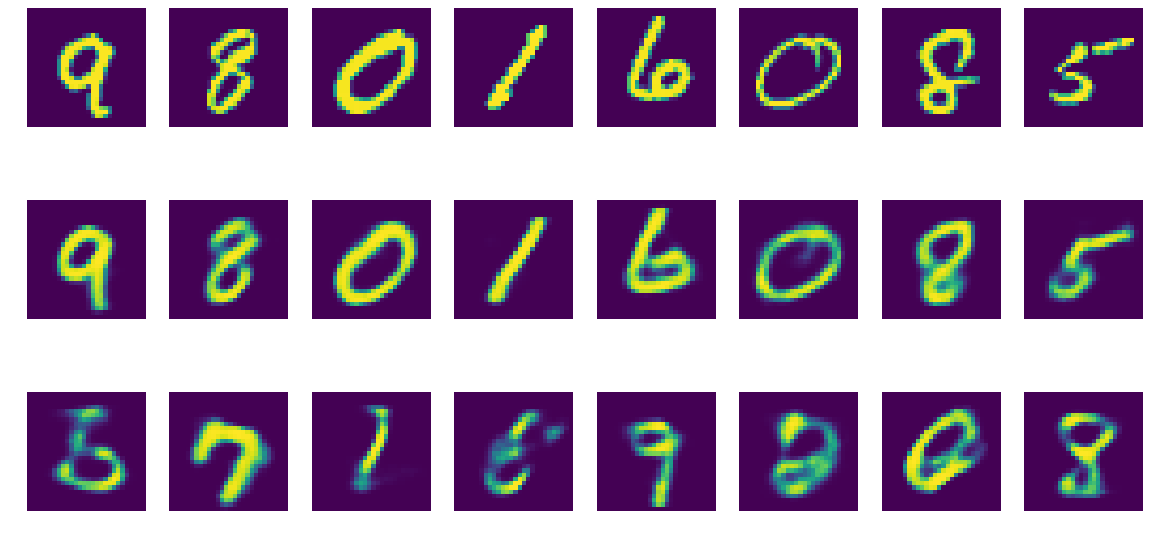

Train Epoch: 7 [0/60000 (0%)]	Loss: 103.862762
Train Epoch: 7 [6400/60000 (11%)]	Loss: 105.242218
Train Epoch: 7 [12800/60000 (21%)]	Loss: 110.006668
Train Epoch: 7 [19200/60000 (32%)]	Loss: 104.107925
Train Epoch: 7 [25600/60000 (43%)]	Loss: 106.996971
Train Epoch: 7 [32000/60000 (53%)]	Loss: 109.132385
Train Epoch: 7 [38400/60000 (64%)]	Loss: 103.132904
Train Epoch: 7 [44800/60000 (75%)]	Loss: 108.976425
Train Epoch: 7 [51200/60000 (85%)]	Loss: 105.545113
Train Epoch: 7 [57600/60000 (96%)]	Loss: 111.855225
====> Epoch: 7 Average loss: 107.6781
====> Test set loss: 107.0870


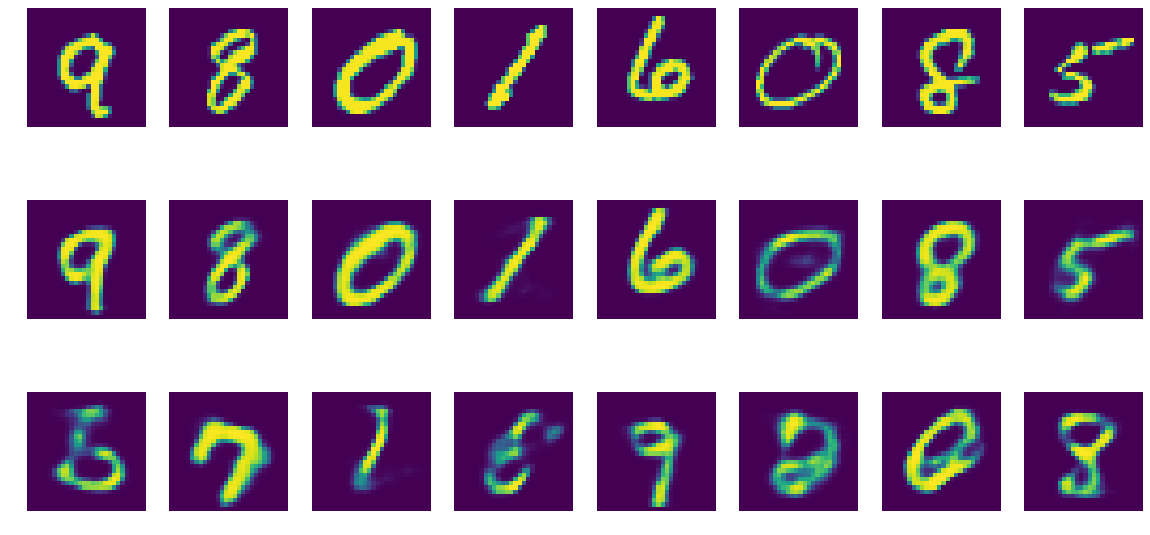

Train Epoch: 8 [0/60000 (0%)]	Loss: 104.440536
Train Epoch: 8 [6400/60000 (11%)]	Loss: 105.928497
Train Epoch: 8 [12800/60000 (21%)]	Loss: 108.058388
Train Epoch: 8 [19200/60000 (32%)]	Loss: 104.279320
Train Epoch: 8 [25600/60000 (43%)]	Loss: 107.142372
Train Epoch: 8 [32000/60000 (53%)]	Loss: 105.119370
Train Epoch: 8 [38400/60000 (64%)]	Loss: 103.002602
Train Epoch: 8 [44800/60000 (75%)]	Loss: 105.969635
Train Epoch: 8 [51200/60000 (85%)]	Loss: 109.034904
Train Epoch: 8 [57600/60000 (96%)]	Loss: 103.237350
====> Epoch: 8 Average loss: 107.0412
====> Test set loss: 106.2919


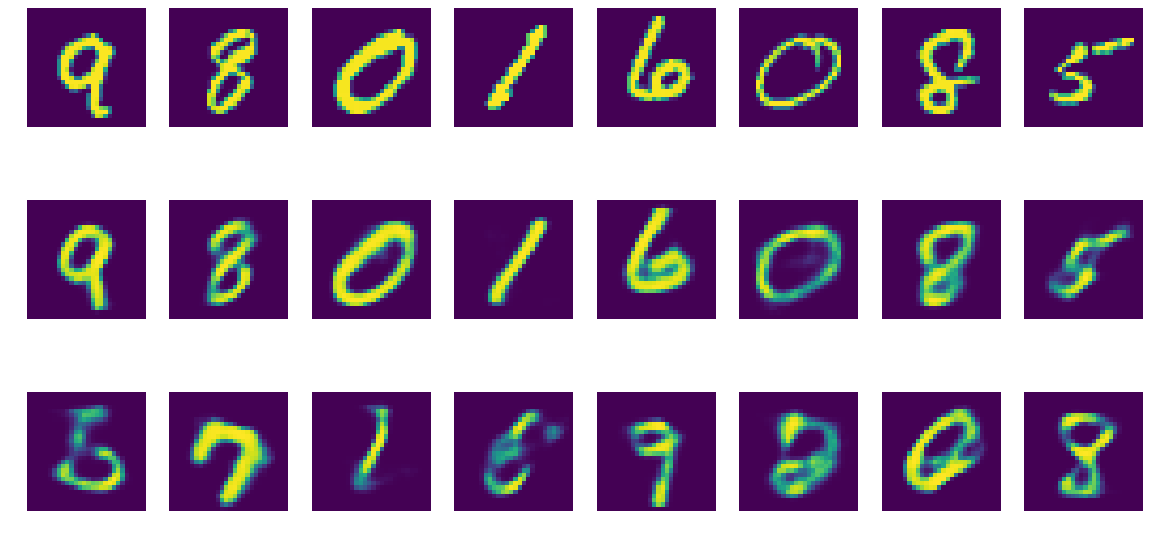

Train Epoch: 9 [0/60000 (0%)]	Loss: 104.955032
Train Epoch: 9 [6400/60000 (11%)]	Loss: 106.156815
Train Epoch: 9 [12800/60000 (21%)]	Loss: 105.734879
Train Epoch: 9 [19200/60000 (32%)]	Loss: 109.663658
Train Epoch: 9 [25600/60000 (43%)]	Loss: 106.348686
Train Epoch: 9 [32000/60000 (53%)]	Loss: 110.283630
Train Epoch: 9 [38400/60000 (64%)]	Loss: 102.677956
Train Epoch: 9 [44800/60000 (75%)]	Loss: 107.962166
Train Epoch: 9 [51200/60000 (85%)]	Loss: 107.206902
Train Epoch: 9 [57600/60000 (96%)]	Loss: 107.106812
====> Epoch: 9 Average loss: 106.5229
====> Test set loss: 105.6392


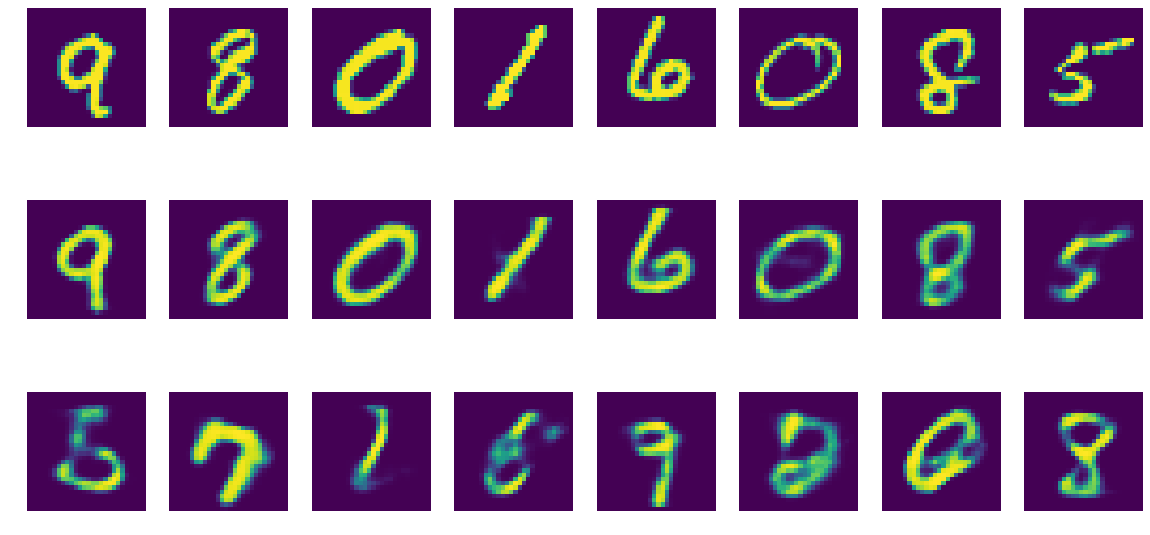

Train Epoch: 10 [0/60000 (0%)]	Loss: 107.820419
Train Epoch: 10 [6400/60000 (11%)]	Loss: 108.066383
Train Epoch: 10 [12800/60000 (21%)]	Loss: 110.881279
Train Epoch: 10 [19200/60000 (32%)]	Loss: 106.822403
Train Epoch: 10 [25600/60000 (43%)]	Loss: 104.011215
Train Epoch: 10 [32000/60000 (53%)]	Loss: 106.947464
Train Epoch: 10 [38400/60000 (64%)]	Loss: 105.659355
Train Epoch: 10 [44800/60000 (75%)]	Loss: 107.479385
Train Epoch: 10 [51200/60000 (85%)]	Loss: 108.168770
Train Epoch: 10 [57600/60000 (96%)]	Loss: 102.480431
====> Epoch: 10 Average loss: 106.0994
====> Test set loss: 105.4876


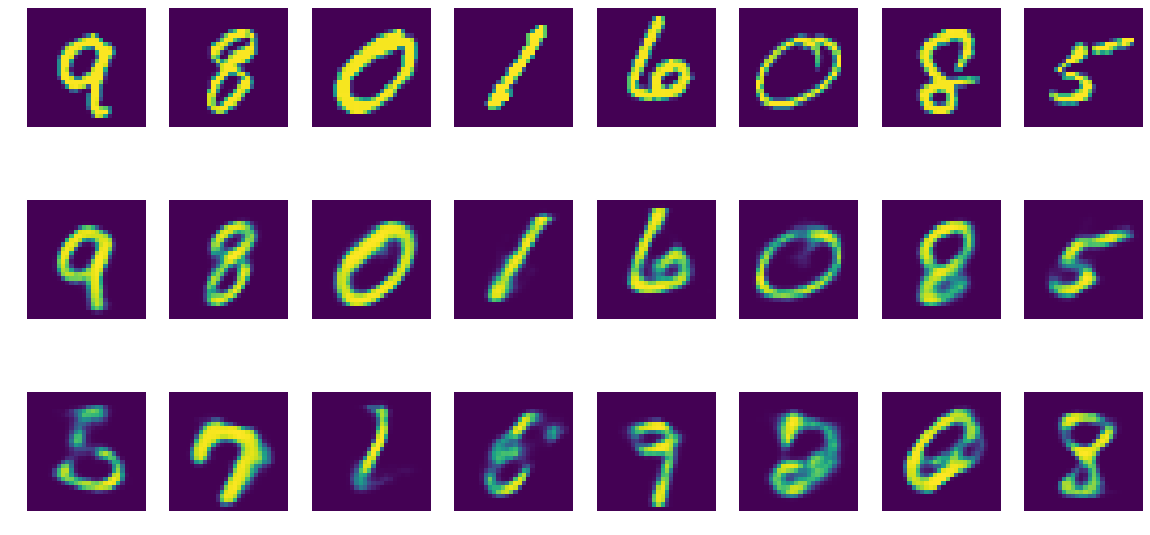

In [29]:
model = VAE().to(device)
print(f"# Parameters: {count_parameters(model)}")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

fixed_z = torch.randn(8, 20).to(device)
fixed_x, _ = next(iter(test_loader))
fixed_x = fixed_x[:8].to(device)

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
    
    fig, axs = plt.subplots(3, 8, figsize=(20, 10))
    with torch.no_grad():
        # Reconstruction
        recon_x, *_ = model(fixed_x)
        for h in range(8):
            axs[0][h].imshow(fixed_x.cpu().numpy()[h].reshape(28, 28))
            axs[0][h].set_axis_off()

        for h in range(8):
            axs[1][h].imshow(recon_x.cpu().numpy()[h].reshape(28, 28))
            axs[1][h].set_axis_off()

        # Generated samples
        fixed_z_gen = model.decode(fixed_z).cpu().numpy()
        
        for h in range(8):
            axs[2][h].imshow(fixed_z_gen[h].reshape(28, 28))
            axs[2][h].set_axis_off()
        plt.show()
